## Imports

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
# Agnostic code set up

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(f"The current device: {device}")

The current device: cuda


### Helper functions

In [4]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())




In [5]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

In [6]:
# Plot the loss and accuracy

def plot_logs(logs):

  plt.plot(logs["epochs"], logs["train_loss"], "g+", label = "Train-loss")
  plt.plot(logs["epochs"], logs["test_loss"], "r+", label = "Test-loss")
  plt.plot(logs["epochs"], logs["train_acc"], "g--", label = "Train-acc")
  plt.plot(logs["epochs"], logs["test_acc"], "r--", label = "Test-acc")
  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.title("Model performance")
  plt.legend(prop = {"size": 8})

## Binary classification

### Data preparation

In [7]:
# Data preparation

n_samples = 1000

data = make_circles(n_samples, noise = 0.03, random_state = 42)

# Splitting into features and target

X = np.asarray(data[0])
y = np.asarray(data[1])

Text(0.5, 1.0, 'Toy dataset -  1000 sample')

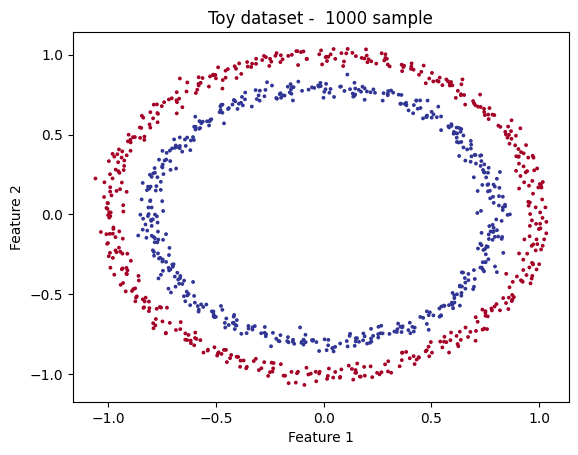

In [8]:
# Visualizing the data

df = pd.DataFrame({"x1": X[ : ,  0], "x2": X[:, 1], "label": y})

plt.scatter(x = df["x1"], y = df["x2"], c = df["label"], cmap = plt.cm.RdYlBu, s = 3)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Toy dataset -  1000 sample")

In [9]:
# Converting data into Tensor

X = torch.from_numpy(X).type(dtype = torch.float).to(device)
y = torch.from_numpy(y).type(dtype = torch.float).unsqueeze(1).to(device)

In [10]:
# Train test split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 1]))

### Model

In [11]:
# Model creation

class BinaryClassification(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


In [16]:
# Model Initialisation

model = BinaryClassification().to(device)

model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6924,  0.1359],
                      [-0.0781, -0.6330],
                      [-0.5769, -0.5748],
                      [-0.1493,  0.3492],
                      [-0.2673,  0.2509],
                      [-0.5084,  0.5658],
                      [ 0.4193, -0.1686],
                      [ 0.5240,  0.1901],
                      [ 0.2896,  0.3678],
                      [ 0.4104,  0.5813]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.6250,  0.1477,  0.0725,  0.0483, -0.0578, -0.5152, -0.2602, -0.4680,
                       0.2976, -0.4039], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2149,  0.2464, -0.2955,  0.0769, -0.3142,  0.1830, -0.1873, -0.3095,
                       -0.1008,  0.0962]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.0446], device='cuda:0'))])

In [17]:
# Optimizer and Loss function


## Binary cross entropy loss with logits

loss_fn = torch.nn.BCEWithLogitsLoss()

## Optimizer stochastic gradient descent

optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01 )

### Training and testing loop

In [18]:
# Accuracy

def accuracy(y_pred, y_test):
  correct = torch.eq(y_pred, y_test).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [30]:

def trainer(x_train, x_test, y_train, y_test, epochs, model):

  # Initilising the loggers

  epoch_count = []
  loss_values = []
  test_loss_values = []
  train_accuracy = []
  test_accuracy = []

  # Moving model to device
  model = model.to(device)



  for epoch in range(epochs):

    # Train mode
    model.train()

    # Feed forward
    y_logits = model(x_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate accuracy
    train_acc = accuracy(y_pred, y_train)

    # Calculate loss
    loss =loss_fn(y_logits, y_train)

    # Reset optimizer
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    if epoch % 10 == 0:

      # Test mode
      model.eval()

      with torch.inference_mode():

        # Test prediction
        y_logits = model(x_test)
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Test accuracy
        test_acc = accuracy(y_pred, y_test)

        # Test loss
        test_loss = loss_fn(y_logits, y_test)

      # Logging

      epoch_count.append(epoch)
      loss_values.append(loss.item())
      test_loss_values.append(test_loss.item())
      train_accuracy.append(train_acc)
      test_accuracy.append(test_acc)

  return {"epochs":epoch_count, "train_loss": loss_values, "test_loss": test_loss_values, "train_acc": train_accuracy, "test_acc":test_accuracy, "model": model}





### Inference

In [20]:
# Training the model - 100 epochs

logs = trainer(x_train, x_test, y_train, y_test, 100, model = model)

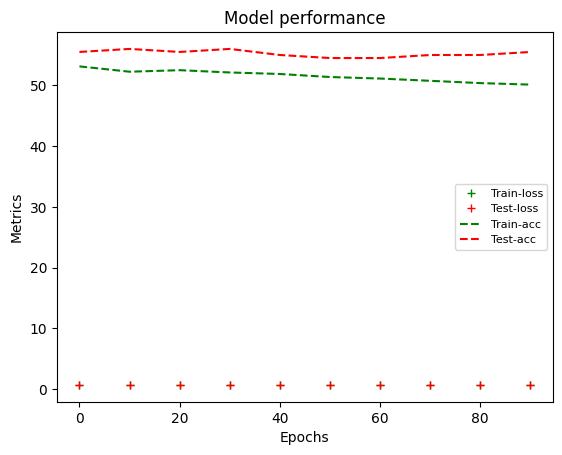

In [21]:
# Visualize

plot_logs(logs)

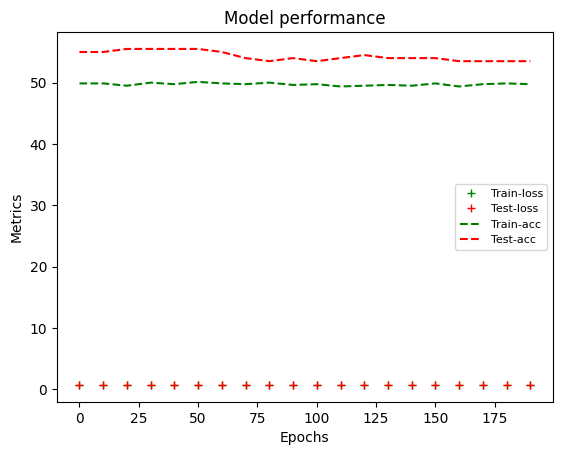

In [22]:
# Train for another 200

logs = trainer(x_train, x_test, y_train, y_test, 200, model)

# Visualize

plot_logs(logs)

**Note:** Even after the loss went down to near zero. The accuracy hasnt improved a little.

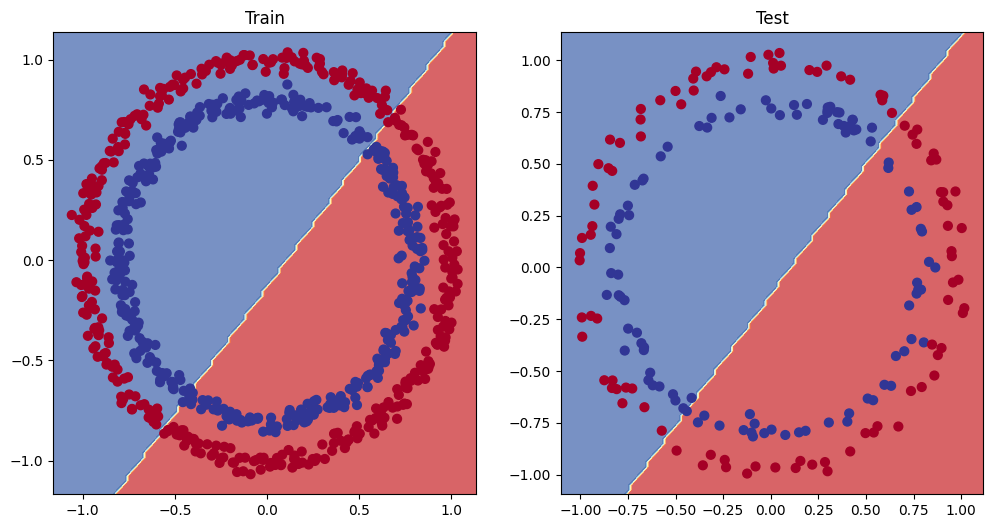

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

**Note:** Label does not have linear boundry between them. but we are using linear layer in the model. we have to add non-linearity to the linear layer to create non linearity in models parameter to fit the data.

### Model with non linear activation

In [24]:
# Model building

class BinaryClassificationNLA(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):

    return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

In [25]:
# Initialise the model

model_1 = BinaryClassificationNLA().to(device)

model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6188, -0.4776],
                      [-0.6769,  0.2697],
                      [-0.1854, -0.1410],
                      [-0.6669, -0.0211],
                      [-0.4825,  0.4382],
                      [-0.5931, -0.3904],
                      [ 0.5721,  0.1036],
                      [ 0.3611, -0.3639],
                      [-0.0871,  0.3796],
                      [-0.6838, -0.5271]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.6761, -0.6160,  0.3940, -0.5410, -0.4887, -0.4707,  0.6763,  0.0076,
                      -0.1452,  0.3908], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.0053, -0.1984,  0.0765,  0.2597, -0.0278, -0.2233,  0.2843, -0.1720,
                       -0.0093, -0.2960],
                      [-0.1836, -0.2714,  0.1129,  0.2602, -0.2906, -0.0665,  0.0390, -0.0140,
                        0.0621, -0.0699],
                      [-0.1482,  0.066

In [26]:
# Optimizer and loss functions

loss_fn = nn.BCEWithLogitsLoss()

# Optimizer - increasing the learning rate from 0.01 to 0.1

optimizer = torch.optim.SGD(params = model_1.parameters(), lr =0.1)

### Train with Non-linear activation

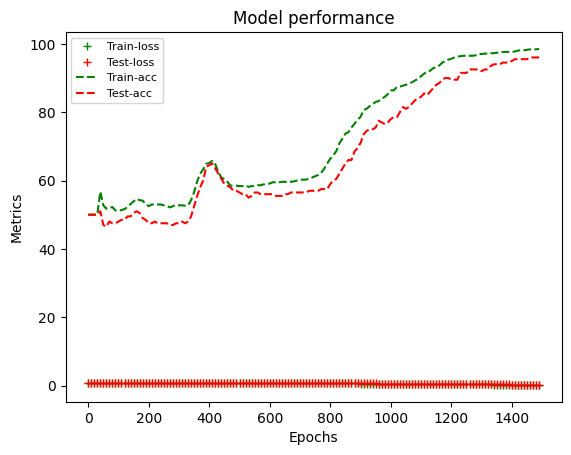

In [27]:
# epochs = 1000

logs = trainer(x_train, x_test, y_train, y_test, 1500, model = model_1)

# Visualize

plot_logs(logs)

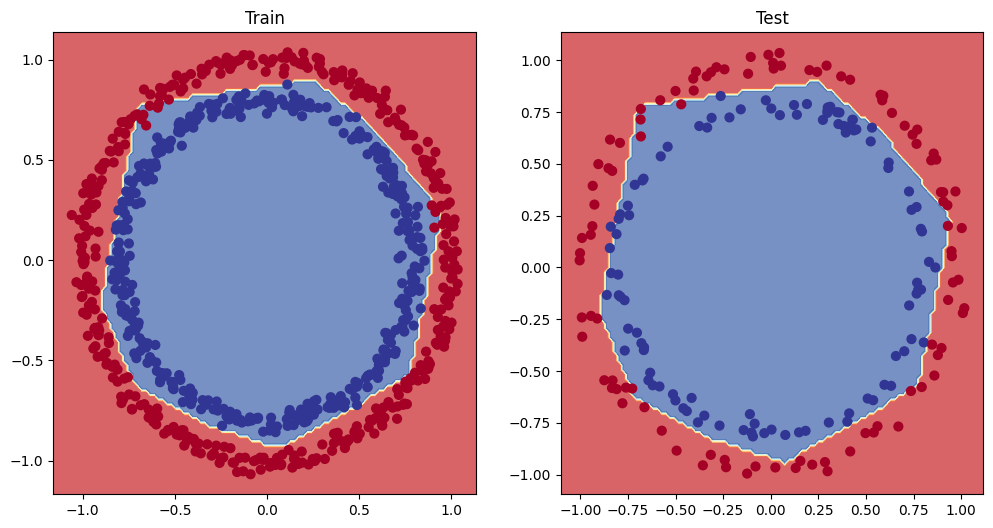

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(logs["model"], x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(logs["model"], x_test, y_test)

we can see some non-linearity in model parameters. let make more epochs.

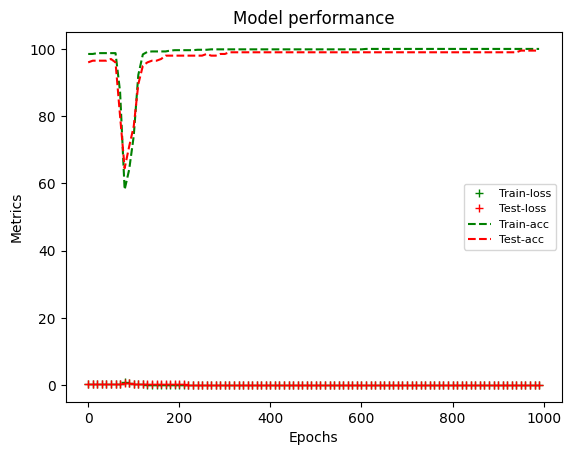

In [31]:
# epochs = 1000

logs = trainer(x_train, x_test, y_train, y_test, 1000, model = logs["model"])

# Visualize

plot_logs(logs)

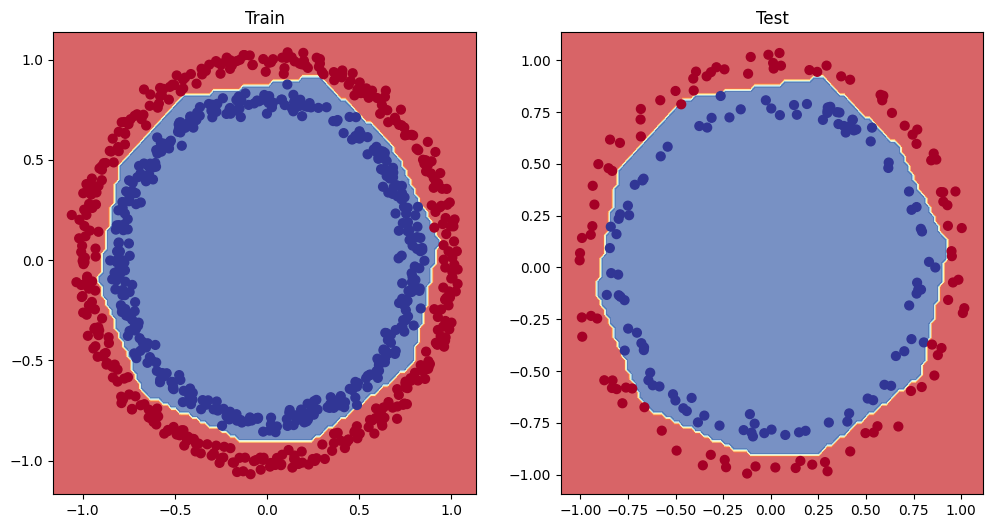

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(logs["model"], x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(logs["model"], x_test, y_test)

In [33]:
print(f"\nTraining accuracy: {logs['train_acc'][ -5 :]}\ntesting_accuracy: {logs['test_acc'][-5:]}\ntrain loss: {logs['train_loss'][-5:]}\ntest loss: {logs['test_loss'][-5:]}")


Training accuracy: [100.0, 100.0, 100.0, 100.0, 100.0]
testing_accuracy: [99.5, 99.5, 99.5, 99.5, 99.5]
train loss: [0.026949390769004822, 0.026634782552719116, 0.02632700465619564, 0.02602585218846798, 0.02573079988360405]
test loss: [0.05263933539390564, 0.05224291980266571, 0.05185290053486824, 0.051470041275024414, 0.05109470710158348]


**Results:** we can see with Non-linear activation and some hyper parameter tuning ( epochs= 2000, learning rate = 0.1). we can achieve nearly

## Multiclass classification

In [34]:
from sklearn.datasets import make_blobs

### Data prepration

In [41]:
# Data

n_features = 2
n_labels = 4
n_samples = 1500

data = make_blobs(n_samples = n_samples, n_features = n_features, centers= n_labels, random_state = 42, cluster_std = 1.5)

In [42]:
# Splitting the data into features and labels

X = data[0]
y = data[1]

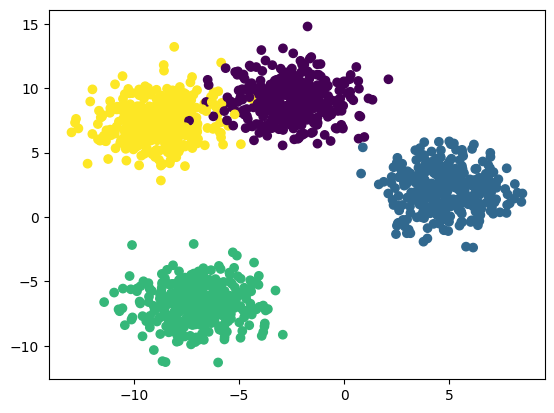

In [43]:
# Visualising the data

# temp data frame

df =pd.DataFrame({"x1":X[ : , 0], "x2": X[ : , 1], "label": y})


plt.scatter(x = df["x1"], y = df["x2"], c= df["label"])


In [44]:
# Converting into tensor

X = torch.from_numpy(X).type(dtype = torch.float).to(device)
y = torch.from_numpy(y).type(dtype =  torch.LongTensor).to(device)

print(X.shape, y.shape)

torch.Size([1500, 2]) torch.Size([1500])


In [46]:
# train test split

x_train, x_test, y_train, y_test = train_test_split(X.cpu(), y.cpu(), test_size = 0.20, stratify=y.cpu())

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([1200, 2]) torch.Size([300, 2]) torch.Size([1200]) torch.Size([300])


### Model built

In [47]:

class MulticlassClassification(nn.Module):

  def __init__(self, in_features, out_features, hidden_layers):

    super().__init__()

    self.linear_layer_stack = nn.Sequential(nn.Linear(in_features = in_features, out_features = hidden_layers),
                                            nn.Linear(in_features = hidden_layers, out_features = hidden_layers),
                                            nn.Linear(in_features = hidden_layers, out_features = out_features))


  def forward(self, x):

    return self.linear_layer_stack(x)

In [48]:
# Initialize the model

model_2 = MulticlassClassification(in_features = 2, out_features =4, hidden_layers = 8).to(device)


model_2.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.2238, -0.3017],
                      [-0.0129,  0.6864],
                      [-0.0092,  0.6149],
                      [ 0.0216, -0.2223],
                      [ 0.2908,  0.6349],
                      [ 0.0919, -0.3999],
                      [-0.3614, -0.5595],
                      [ 0.2189, -0.1405]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([-0.6729,  0.3815, -0.4789,  0.1669, -0.6983, -0.0415, -0.1624,  0.6591],
                     device='cuda:0')),
             ('linear_layer_stack.1.weight',
              tensor([[-0.1343, -0.0444,  0.0033, -0.0399, -0.1045, -0.2084, -0.1093, -0.2462],
                      [-0.2477, -0.1831,  0.0831,  0.3326, -0.0354, -0.0788,  0.0781, -0.0550],
                      [-0.1140, -0.0924, -0.0692, -0.2682,  0.1793,  0.2805,  0.2441, -0.2265],
                      [-0.0918,  0.0815,  0.3452,  0.1638, -0.2997,  0.0377,  0.0125,  0

In [49]:
# Optimizer and loss functions

loss_fn = nn.CrossEntropyLoss()

# Optimizer

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

### Training loop

In [52]:
def trainer(x_train, x_test, y_train, y_test, epochs, model):

  # Initialize the loggers

  epoch_count = []
  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []

  # MOvng model to device
  model = model.to(device)
  x_train = x_train.to(device)
  x_test = x_test.to(device)
  y_train = y_train.to(device)
  y_test = y_test.to(device)

  for epoch in range(epochs):

    # Train mode
    model.train()

    # Forward
    y_logits = model(x_train)

    ## y_pred
    y_pred = torch.argmax( torch.softmax(y_logits, dim =1), dim = 1)
    ## Accuracy
    train_accuracy = accuracy(y_pred, y_train)

    # Calculate the loss

    loss = loss_fn(y_logits, y_train)

    # Reset optimizer
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    if epoch % 20 == 0:

      # Eval mode
      model.eval()

      # Inference mode
      with torch.inference_mode():

        y_logits = model(x_test)

        ## y_pred
        y_pred = torch.argmax( torch.softmax( y_logits, dim = 1), dim = 1)

        ## Test accuracy
        test_accuracy = accuracy(y_pred, y_test)

        # Calculate the loss
        loss_test = loss_fn(y_logits, y_test)

        # Logging
        epoch_count.append(epoch)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        train_loss.append(loss.item())
        test_loss.append(loss_test.item())


  return {"epochs": epoch_count, "train_loss": train_loss, "test_loss": test_loss, "train_acc": train_acc, "test_acc": test_acc, "model": model}




### Inference

In [53]:
# Training for 1000

logs = trainer(x_train, x_test, y_train, y_test, epochs = 1000, model = model_2)

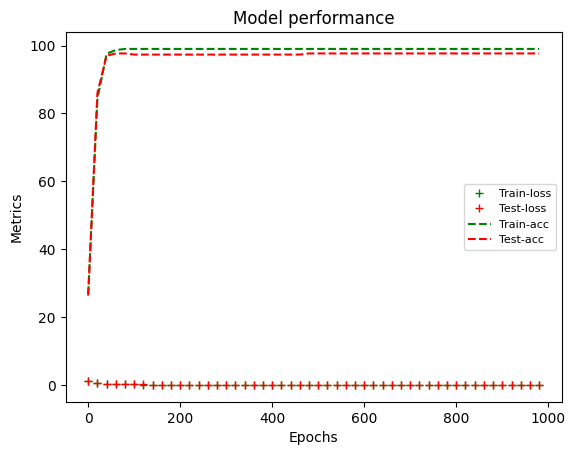

In [54]:
# plot loggs

plot_logs(logs)

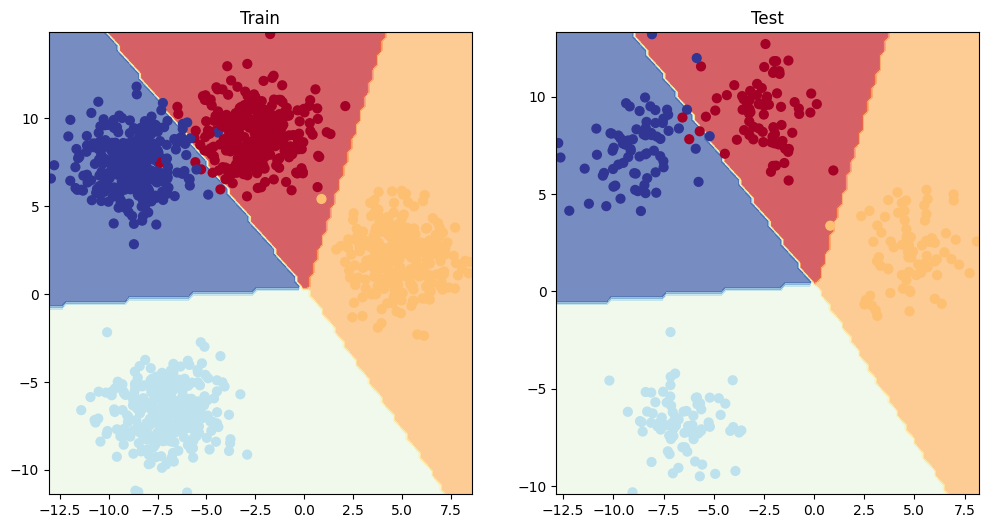

In [55]:
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model = logs["model"], X = x_train, y = y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model = logs["model"], X = x_test, y = y_test)